# OpenQAOA Example: Manual Mode

In [21]:
from openqaoa.qaoa_parameters import PauliOp, Hamiltonian, QAOACircuitParams, create_qaoa_variational_params
# from eqaoa.qaoa_parameters.baseparams import QAOACircuitParams
from openqaoa.backends.qpus.qpu_auth import AccessObjectQiskit
from openqaoa.backends.qaoa_backend import *
from openqaoa.optimizers import get_optimizer
from qiskit import QuantumCircuit
from openqaoa.utilities import *

### Define Cost and Mixer Hamiltonians with ease!

In [2]:
cost_hamil = Hamiltonian([PauliOp('ZZ', (0, 1)), PauliOp('ZZ', (1, 2)), PauliOp('ZZ', (0, 2))], 
                         [1, 1, 1], 1)

In [3]:
classical_terms = [(0, 1),(1, 2),(0, 2)]
coeffs = [1, 1, 1]
constant = 1
cost_hamil = Hamiltonian.classical_hamiltonian(terms=classical_terms,coeffs=coeffs,constant=constant)
cost_hamil.expression

1 + 1Z_{0}Z_{1} + 1Z_{0}Z_{2} + 1Z_{1}Z_{2}

In [4]:
mixer_hamil = X_mixer_hamiltonian(n_qubits=3)

### Define QAOA Circuit Parameters
QAOA Circuit Params encode the cost and mixer hamiltonians in the form of an Abstract circuit which will later be used for constructing respective backend circuits

In [5]:
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil, p=2)

### Define QAOA Variational Parameters
* Variational Params will be used to run QAOA computations to compute, for instance, expectation values. They are designed to be updated easily using an optimiser during VQA optimisation routines
* The user can specify the desired parameterization and initialization strategy 

In [6]:
variate_params = create_qaoa_variational_params(circuit_params,'standard','ramp')

### Define the Backend of your choice!
* Choose from the available local/cloud based devices including IBMQ, Rigetti QPUs
* Depending on whether the chosen device is cloud-based or local, you may have to define an authentication dictionary with your credentials as follows

In [7]:
AccessObjectQiskit?

Init signature:
AccessObjectQiskit(
    api_token: str,
    hub: str,
    group: str,
    project: str,
    selected_qpu: str = '',
) -> None
Docstring:     
Contains the required information and methods needed to access remote
qiskit QPUs.

Attributes:
    available_qpus (list): When connection to a provider is established, 
                           this attribute contains a list of backend names 
                           which can be used to access the selected backend 
                           by reinitialising the Access Object with the 
                           name of the available backend as input to the 
                           selected_backend parameter.
Init docstring:
A majority of the input parameters required for this can be found in
the user's IBMQ Experience account.

Parameters
----------
api_token: str
    Valid IBMQ Experience Token.
hub: str
    Valid IBMQ hub name.
group: str
    Valid IBMQ group name. 
project: str
    The name of the project for which t

In [8]:
auth_dict = { "QISKIT": 
             { "API_TOKEN": "18f727c8e07dda9348d45299275c94b55b70c96c4f23e59f7e6a194cd2e05821ef2b6a1bb337a80e1614dc512ca7b0bb43c17b6a9bf844dc0d6f76982de12b0a",#"<API TOKEN>",#
              "HUB": "ibm-q", 
              "GROUP": "open", 
              "PROJECT": "main"}
            }

selected_device = 'ibmq_qasm_simulator'

access_obj = AccessObjectQiskit(auth_dict["QISKIT"]["API_TOKEN"], auth_dict["QISKIT"]["HUB"], 
                   auth_dict["QISKIT"]["GROUP"], auth_dict["QISKIT"]["PROJECT"], selected_device)

In [22]:
backend_cloud?

Type:        QAOAQiskitQPUBackend
String form: <openqaoa.backends.qpus.qaoa_qiskit_qpu.QAOAQiskitQPUBackend object at 0x7fec54f22f40>
File:        ~/Documents/Github/openqaoa/openqaoa/backends/qpus/qaoa_qiskit_qpu.py
Docstring:  
A QAOA simulator as well as for real QPU using qiskit as the backend

Parameters
----------
access_object: `AccessObjectQiskit`
    An object of the class ``AccessObjectQiskit`` which contains the credentials
    for accessing the QPU via cloud
circuit_params: `QAOACircuitParams`
    An object of the class ``QAOACircuitParams`` which contains information on 
    circuit construction and depth of the circuit.
n_shots: `int`
    The number of shots to be taken for each circuit.
prepend_state: `QuantumCircuit`
    The state prepended to the circuit.
append_state: `QuantumCircuit`
    The state appended to the circuit.
init_hadamard: `bool`
    Whether to apply a Hadamard gate to the beginning of the 
    QAOA part of the circuit.
cvar_alpha: `float`
    The value

In [9]:
backend_cloud = get_qaoa_backend(circuit_params, access_obj, n_shots=1000)

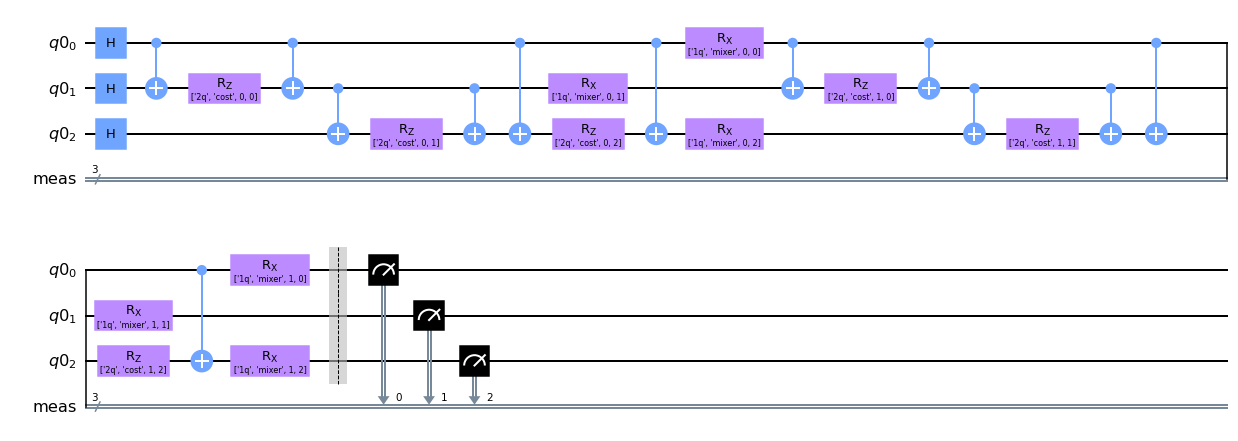

In [10]:
backend_cloud.parametric_circuit.draw('mpl')

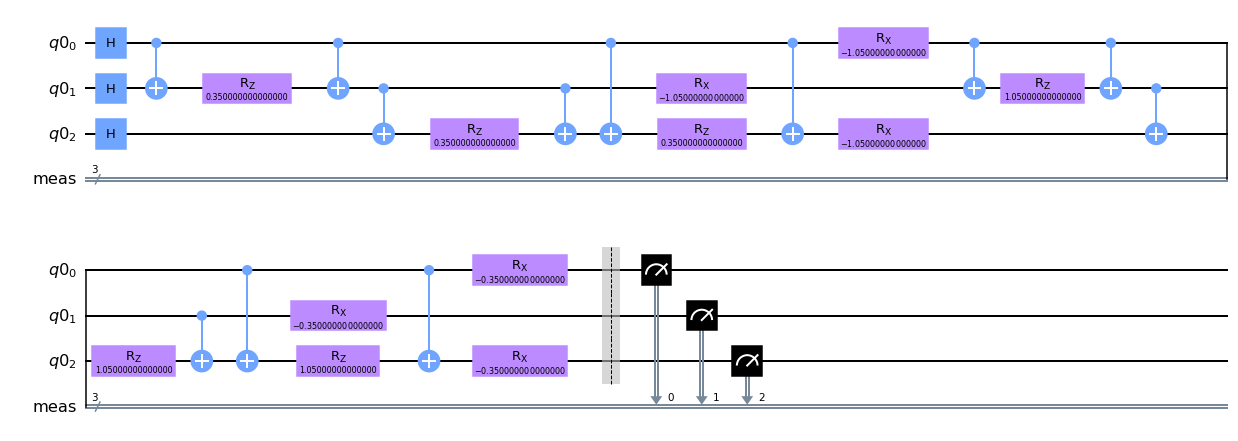

In [11]:
backend_cloud.qaoa_circuit(variate_params).draw('mpl')

### Creating other backends

In [12]:
backend_qiskit_statevec = get_qaoa_backend(circuit_params, 'qiskit_statevec_simulator')

In [14]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ
# IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-startup','entropica-labs','reservations')
backend = provider.get_backend('ibmq_bogota')
noise_model = NoiseModel.from_backend(backend)

In [15]:
backend_qiskit_shot = get_qaoa_backend(circuit_params, 'qiskit_shot_simulator', n_shots=100, noise_model=noise_model)

In [16]:
print(backend_qiskit_statevec.expectation(variate_params))
print(backend_qiskit_statevec.expectation_w_uncertainty(variate_params))

0.006166710717490102
(0.006166710717490102, 0.15693570195748066)


In [17]:
print(backend_qiskit_shot.expectation(variate_params))
print(backend_qiskit_shot.expectation_w_uncertainty(variate_params))

0.0
(0.0, 0.0)


In [53]:
current_ckt = backend_qiskit_shot.qaoa_circuit(variate_params)

In [54]:
#print parametric qaoa circuit
backend_qiskit_shot.parametric_circuit.draw()

┌───┐                                                      »
  q6_0: ┤ H ├─■────────────────────────────────────────────────────»
        ├───┤ │ZZ(['2q', 'cost', 0, 0])                            »
  q6_1: ┤ H ├─■──────────────────────────■─────────────────────────»
        ├───┤                            │ZZ(['2q', 'cost', 0, 1]) »
  q6_2: ┤ H ├────────────────────────────■─────────────────────────»
        └───┘                                                      »
meas: 3/═══════════════════════════════════════════════════════════»
                                                                   »
«                                   ┌───────────────────────────┐»
«  q6_0: ─■─────────────────────────┤ Rx(['1q', 'mixer', 0, 0]) ├»
«         │                         ├───────────────────────────┤»
«  q6_1: ─┼─────────────────────────┤ Rx(['1q', 'mixer', 0, 1]) ├»
«         │ZZ(['2q', 'cost', 0, 2]) ├───────────────────────────┤»
«  q6_2: ─■─────────────────────────┤ Rx(['1q', 'mixer', 0, 2]) ├»
«                                   └───────────────────────────┘»
«meas: 3/════════════════════════════════════════════════════════»
«                                                                »
«                                                              »
«  q6_0: ─■────────────────────────────────────────────────────»
«         │ZZ(['2q', 'cost', 1, 0])                            »
«  q6_1: ─■──────────────────────────■─────────────────────────»
«                                    │ZZ(['2q', 'cost', 1, 1]) »
«  q6_2: ────────────────────────────■─────────────────────────»
«                                                              »
«meas: 3/══════════════════════════════════════════════════════»
«                                                              »
«                                   ┌───────────────────────────┐ ░ ┌─┐      
«  q6_0: ─■─────────────────────────┤ Rx(['1q', 'mixer', 1, 0]) ├─░─┤M├──────
«         │                         ├───────────────────────────┤ ░ └╥┘┌─┐   
«  q6_1: ─┼─────────────────────────┤ Rx(['1q', 'mixer', 1, 1]) ├─░──╫─┤M├───
«         │ZZ(['2q', 'cost', 1, 2]) ├───────────────────────────┤ ░  ║ └╥┘┌─┐
«  q6_2: ─■─────────────────────────┤ Rx(['1q', 'mixer', 1, 2]) ├─░──╫──╫─┤M├
«                                   └───────────────────────────┘ ░  ║  ║ └╥┘
«meas: 3/════════════════════════════════════════════════════════════╩══╩══╩═
«                                                                    0  1  2

In [55]:
#print the full circuit with attached angles
current_ckt.draw()

┌───┐                                                »
  q6_0: ┤ H ├─■──────────────────────────────────────────────»
        ├───┤ │ZZ(0.350000000000000)                         »
  q6_1: ┤ H ├─■───────────────────────■──────────────────────»
        ├───┤                         │ZZ(0.350000000000000) »
  q6_2: ┤ H ├─────────────────────────■──────────────────────»
        └───┘                                                »
meas: 3/═════════════════════════════════════════════════════»
                                                             »
«                                ┌───────────────────────┐»
«  q6_0: ─■──────────────────────┤ Rx(-1.05000000000000) ├»
«         │                      ├───────────────────────┤»
«  q6_1: ─┼──────────────────────┤ Rx(-1.05000000000000) ├»
«         │ZZ(0.350000000000000) ├───────────────────────┤»
«  q6_2: ─■──────────────────────┤ Rx(-1.05000000000000) ├»
«                                └───────────────────────┘»
«meas: 3/═════════════════════════════════════════════════»
«                                                         »
«                                                                             »
«  q6_0: ─■─────────────────────────────────────────────■─────────────────────»
«         │ZZ(1.05000000000000)                         │                     »
«  q6_1: ─■──────────────────────■──────────────────────┼─────────────────────»
«                                │ZZ(1.05000000000000)  │ZZ(1.05000000000000) »
«  q6_2: ────────────────────────■──────────────────────■─────────────────────»
«                                                                             »
«meas: 3/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«        ┌────────────────────────┐ ░ ┌─┐      
«  q6_0: ┤ Rx(-0.350000000000000) ├─░─┤M├──────
«        ├────────────────────────┤ ░ └╥┘┌─┐   
«  q6_1: ┤ Rx(-0.350000000000000) ├─░──╫─┤M├───
«        ├────────────────────────┤ ░  ║ └╥┘┌─┐
«  q6_2: ┤ Rx(-0.350000000000000) ├─░──╫──╫─┤M├
«        └────────────────────────┘ ░  ║  ║ └╥┘
«meas: 3/══════════════════════════════╩══╩══╩═
«                                      0  1  2

In [59]:
backend_cloud.expectation_w_uncertainty(variate_params)

(0.008, 0.17870646322950942)

In [60]:
backend_qiskit_statevec.qfim(variate_params)

<function openqaoa.basebackend.QAOABaseBackendStatevector.qfim.<locals>.qfim_fun(args)>

In [ ]:
optimizer_dict = {'method': 'cobyla', 'maxiter': 10}

In [ ]:
optimizer_obj = get_optimizer(backend_qiskit_shot, variate_params, optimizer_dict)

In [ ]:
optimizer_obj

Optimizer for VQA of type: QAOABaseBackendShotBased 
Backend: QAOAQiskitBackendShotBasedSimulator 
Method: COBYLA with Max Iterations: 10

In [ ]:
optimizer_obj()
optimizer_obj.results_information()

{'opt result':      fun: 0.16796875
    maxcv: 0.0
  message: 'Maximum number of function evaluations has been exceeded.'
     nfev: 10
   status: 2
  success: False
        x: array([ 0.23860891, -0.49749158, -0.55008868,  0.57481587]),
 'parameter log': [[0.5249999999999999, 0.175, 0.175, 0.5249999999999999],
  [1.525, 0.175, 0.175, 0.5249999999999999],
  [0.5249999999999999, 1.175, 0.175, 0.5249999999999999],
  [0.5249999999999999, 0.175, 1.175, 0.5249999999999999],
  [0.5249999999999999, 0.175, 0.175, 1.525],
  [0.4285719711458033,
   -0.4974915778532932,
   -0.5500886845010369,
   0.4122919143262636],
  [0.31475014759370734,
   -1.2912879317166122,
   0.03234817895156872,
   0.27925341926537217],
  [0.3133479216391065,
   -0.24268654978312187,
   -0.9420833244246505,
   0.2776144538638907],
  [0.23860890950689823,
   -0.4974915778532932,
   -0.5500886845010369,
   0.5748158670617713],
  [0.531542560099041,
   -0.5287021363367402,
   -0.6856147964570463,
   0.955405475916242]],
 'f

In [ ]:
optimizer_obj()
optimizer_obj.results_information()

{'opt result':      fun: 0.1171875
    maxcv: 0.0
  message: 'Maximum number of function evaluations has been exceeded.'
     nfev: 10
   status: 2
  success: False
        x: array([ 0.49041297, -0.5005708 , -0.54492259,  0.23068843]),
 'parameter log': [[0.5249999999999999, 0.175, 0.175, 0.5249999999999999],
  [1.525, 0.175, 0.175, 0.5249999999999999],
  [0.5249999999999999, 1.175, 0.175, 0.5249999999999999],
  [0.5249999999999999, 0.175, 1.175, 0.5249999999999999],
  [0.5249999999999999, 0.175, 0.175, 1.525],
  [0.4285719711458033,
   -0.4974915778532932,
   -0.5500886845010369,
   0.4122919143262636],
  [0.31475014759370734,
   -1.2912879317166122,
   0.03234817895156872,
   0.27925341926537217],
  [0.3133479216391065,
   -0.24268654978312187,
   -0.9420833244246505,
   0.2776144538638907],
  [0.23860890950689823,
   -0.4974915778532932,
   -0.5500886845010369,
   0.5748158670617713],
  [0.531542560099041,
   -0.5287021363367402,
   -0.6856147964570463,
   0.955405475916242],
  [0.

### Some useful functions to play around with!

In [19]:
from openqaoa.utilities import plot_energy_spectrum

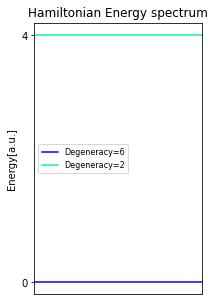

In [20]:
plot_energy_spectrum(cost_hamil)